# pynq-chainer

* Chainerの行列計算の一部をFPGAにオフロード
* PCとPYNQで同じアプリケーションコードが動くようにした

In [32]:
import random
import numpy as np
import cffi

try:
    from pynq import Overlay

    # load Base Overlay
    Overlay("/home/xilinx/pynq/bitstream/base.bit").download()

    from pynq.drivers import xlnk
    IS_PYNQ = True
except:
    IS_PYNQ = False
    
import chainer
from chainer import links as L
from chainer import functions as F
from chainer import Variable

import sys
sys.path.append("..")

from pynq_chainer import utils

%matplotlib inline
import matplotlib.pyplot as plt
import sys

In [4]:
IS_PYNQ

False

In [6]:
if IS_PYNQ:
    mmu = xlnk.xlnk()
    mmu.xlnk_reset()

In [7]:
train, test = chainer.datasets.get_mnist()

In [8]:
idx = random.randint(0, len(train))
x, label = train[idx]
print(label)

0


In [9]:
input_image = x[np.newaxis,:]
input_image = input_image.astype(np.float32)
input_image = chainer.Variable(input_image)

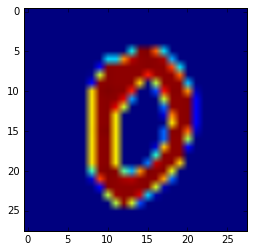

In [10]:
img = x.reshape(28,28)
plt.imshow(img)

# CPU 

In [33]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__(
            # the size of the inputs to each layer will be inferred
            l1=L.Linear(None, n_units, nobias=True),  # n_in -> n_units
            l2=L.Linear(None, n_units, nobias=True),  # n_units -> n_units
            l3=L.Linear(None, n_out, nobias=True),  # n_units -> n_out
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = self.l3(h2)
        return h3

In [34]:
mlp_cpu = MLP(n_units=32, n_out=10)

resume = "../examples/mnist/mnist_iter_12000.npz"
chainer.serializers.load_npz(resume, mlp_cpu)

h = F.softmax(mlp_cpu(input_image))
y = F.argmax(h)

print(h.data)
print("result", y.data)
print("seikai", label)

[[  9.99916196e-01   1.09165593e-16   4.74979771e-07   4.57928495e-09
    1.28677076e-16   8.20582718e-05   9.98348071e-08   1.48064998e-11
    1.23012825e-07   1.10781036e-06]]
result 0
seikai 0


# FPGA

In [35]:
# replace chainer to pynq-chainer

#from pynq_chainer import functions as F
from pynq_chainer import links as L

In [36]:
mlp_fpga = MLP(n_units=32, n_out=10)

resume = "../examples/mnist/mnist_iter_12000.npz"
chainer.serializers.load_npz(resume, mlp_fpga)

init model cma array W <cdata 'char[]' buffer len 1280 from 'memoryview' object> W
init model cma array W <cdata 'char[]' buffer len 4096 from 'memoryview' object> W
init model cma array W <cdata 'char[]' buffer len 100352 from 'memoryview' object> W


In [37]:
h = mlp_fpga(input_image)
h = F.softmax(h)
y = F.argmax(h)
print(h.data)
print("result", y.data)
print("seikai", label)

[[  9.99916196e-01   1.09166003e-16   4.74980652e-07   4.57927607e-09
    1.28676587e-16   8.20584319e-05   9.98349989e-08   1.48064998e-11
    1.23012953e-07   1.10780718e-06]]
result 0
seikai 0


# Benchmark 

In [40]:
%timeit -n 1 mlp_cpu(input_image)

1 loop, best of 3: 1.15 ms per loop


In [41]:
%timeit -n 1 mlp_fpga(input_image)

1 loop, best of 3: 1.3 ms per loop
